# Linear SVM

[The Support Vector Machine SVM](https://link.springer.com/content/pdf/10.1007%2FBF00994018.pdf) is a linear classifier that finds the **maximum margin** separating hyperplane. In other words, SVM find the separating hyperplane that maximizes the distance to the closest data points from both classes.

In [1]:
#@title Import libraries {display-mode: "form"}

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#@title Helper functions {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

# Helper functions
def draw_grid(x_lim=np.array([-4, 4]), y_lim=np.array([-4, 4])):
    """Draw an empty grid"""
    ax = plt.gca()
    # Draw ticks and grid
    for i in range(int(x_lim.min()), int(x_lim.max())):
        ax.axvline(i, linestyle='--', color='#ecf0f1', zorder=0)
        ax.plot([i, i], [0.05, -0.05], color='#2c3e50')
    for i in range(int(y_lim.min()), int(y_lim.max())):
        ax.axhline(i, linestyle='--', color='#ecf0f1', zorder=0)
        ax.plot([0.05, -0.05], [i, i], color='#2c3e50')
    # x and y axis
    ax.axhline(0, color='#2c3e50', zorder=0)
    ax.axvline(0, color='#2c3e50', zorder=0)
    ax.scatter([0], [0], color='#c0392b', zorder=0)

    ax.grid(False)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

def draw_vectors(vectors, origin='origin', cmap=None, labels=None):
    if cmap:
        colors = cmap
    else:
        colors = ['#3498db', '#e67e22', '#f1c40f', '#2ecc71', '#1abc9c']

    if origin == 'origin':
        x_0 = np.zeros(len(vectors))
        y_0 = np.zeros(len(vectors))
    else:
        x_0, y_0 = origin[:, 0], origin[:, 1]
    ax = plt.gca()
    if labels:
        for i in range(len(vectors)):
            ax.text(vectors[i][0]+0.1, vectors[i][1]+0.2, labels[i],
                    {'color': 'black', 'fontsize': 14, 'ha': 'center', 'va': 'center',
                    'bbox': dict(boxstyle="round", fc="white", alpha=0)})
    ax.quiver(x_0, y_0, vectors[:, 0], vectors[:, 1],
              angles='xy', scale_units='xy', scale=1, color=colors)

def projection(x, y, draw_vector=True):
    color = '#95a5a6'
    ax = plt.gca()
    dot_product = np.dot(x, y)
    y_norm = y / np.dot(y, y)
    x_projection = y_norm * dot_product
    ax.plot((x[0], x_projection[0]), (x[1], x_projection[1]), linestyle='--', linewidth=3, c=color)
    if draw_vector:
        draw_vectors(np.array([x_projection]), cmap=['#bdc3c7'])

def determinant_area(i_hat, j_hat):
    ax = plt.gca()
    sum_vector = i_hat + j_hat
    polygon = plt.Polygon([(0, 0), i_hat, sum_vector, j_hat], fill=True, color='#f39c12', alpha=0.3)
    print('Determinant Area:', np.abs(i_hat[0]*j_hat[1] - i_hat[1]*j_hat[0]))
    ax.add_line(polygon)
    
def projection_onto_H(x, w, b):
    ax = plt.gca()
    alpha = (np.dot(x, w) + b) / np.dot(w, w)
    d = alpha * w
    x_projection = x - d
    ax.plot((x[0], x_projection[0]), (x[1], x_projection[1]), linestyle='--', linewidth=3, c='#95a5a6')
    
def plot_margins(X, y, w, b):
    ax = plt.gca()
    gamma = np.abs(np.dot(X, w) + b) / np.sqrt(np.dot(w, w))
    x_pos = X[y==1][np.argmin(gamma[y == 1])]
    x_neg = X[y==0][np.argmin(gamma[y == 0])]
    d_pos = gamma[y==1][np.argmin(gamma[y == 1])]
    d_neg = gamma[y==0][np.argmin(gamma[y == 0])]
    
    ax.scatter([x_pos[0], x_neg[0]],[x_pos[1], x_neg[1]], s=150, linewidth=2, facecolor='none', edgecolors='#2c3e50')
    projection_onto_H(x_pos, w, b)
    projection_onto_H(x_neg, w, b)
    ax.set_title(f'Margin Class +1: {d_pos:.3f}, Class -1: {d_neg:.3f}', fontsize=24)
    
def plot_svc(model, plot_support=True):
    ax = plt.gca()
    xlim = ax.get_xlim() 
    ylim = ax.get_ylim() 
    
    # create grid (coordinate system - x and y) to evaluate model
    x = np.linspace(xlim[0], xlim[1], 40)
    y = np.linspace(ylim[0], ylim[1], 40) 
    X, Y = np.meshgrid(x, y)
    flatten_X = X.ravel() 
    flatten_Y = Y.ravel()
    xy = np.vstack([flatten_X, flatten_Y]).T 
    Z = model.decision_function(xy).reshape(X.shape)

    # Plot decision boundary and margins.
    ax.contour(X, Y, Z, colors='k', # draw filled contours
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    
    # plot circle around the support vectors returned by fitted SVC model
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], 
                   model.support_vectors_[:, 1],
                   s=150, linewidth=2, facecolors='none', edgecolors='k')
        
def plot_hyperplane(w, b):
    ax = plt.gca()
    draw_vectors(np.array([w]), origin=np.array([[(-b/w[0]), 0]]))
    x_1 = np.linspace(-8, 8, 100)
    ax.plot(x_1, (-w[0]/w[1])*x_1 + (-b/w[1]))

In [3]:
w = np.array([-1, 1])
b = -6

# Logistic Regression result
w = np.array([-1.6088516, 0.26800105])
b = -3.52428733

# The hyperplane doesn't change when we scale w and b
# w = 3*w
# b = 3*b

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, n_features=2, centers=2, random_state=102, cluster_std=1.)


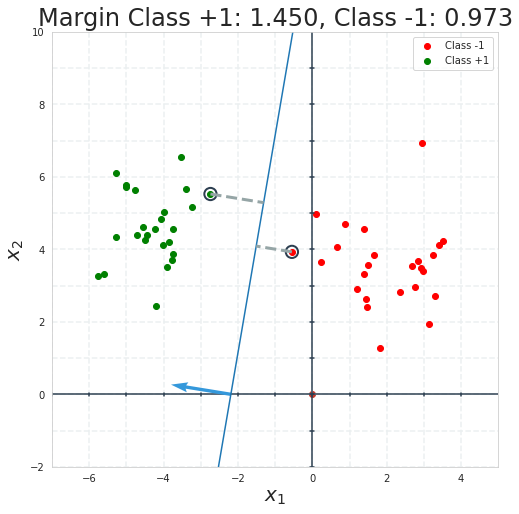

In [4]:
#@title Hyperplane with margins {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

# Hyperplane example

plt.figure(figsize=(8, 8))
draw_grid(x_lim=np.array([-7, 5]), y_lim=np.array([-2, 10]))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='r', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='g', label='Class +1')

plot_hyperplane(w, b)
plot_margins(X, y, w, b)

plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$x_2$', fontsize=20)
plt.legend()
plt.show()

## Max Margin Classifier

A hyperplane is defined through $\mathbf{w}$ and $b$ as a set of point such that $\mathcal{H}=\left\{\mathbf{x}\vert{}\mathbf{w}^T\mathbf{x}+b=0\right\}$. Then the margin $\gamma$ is the distance from the hyperplane to the closest point across both classes.

### What is the margin of the hyperplane $\mathcal{H}$ with respect to $D$?

Let $\mathbf{d}$ be the vector from $\mathcal{H}$ to $\mathbf{x}$ with minimum length. Let $\mathbf{x}_p$ be the projection of $\mathbf{x}$ onto $\mathcal{H}$. Then:

$$
\begin{align}
\mathbf{x}_p &= \mathbf{x} - \mathbf{d} &\\
\mathbf{d} &= \alpha \mathbf{w} &\text{ for $\alpha \in R$} \\
\mathbf{w}^T\mathbf{x}_p + b &= 0 & \text{because $\mathbf{x}_p \in \mathcal{H}$} \\
\end{align}
$$

Therefore

$$
\mathbf{w}^T\mathbf{x}_P+b=\mathbf{w}^T(\mathbf{x}-\mathbf{d})+b=\mathbf{w}^T(\mathbf{x}-\alpha\mathbf{w})+b=0
$$

$$
\Rightarrow
\alpha=\frac{\mathbf{w}^T\mathbf{x}+b}{\mathbf{w}^T\mathbf{w}}
$$

The length of $\mathbf{d}$:

$$
\left \| \mathbf{d} \right \|_2=\sqrt{\mathbf{d}^T\mathbf{d}}=\sqrt{\alpha^2\mathbf{w}^T\mathbf{w}}=\frac{\left | \mathbf{w}^T\mathbf{x}+b \right |}{\sqrt{\mathbf{w}^T\mathbf{w}}}=\frac{\left | \mathbf{w}^T\mathbf{x}+b \right |}{\left \| \mathbf{w} \right \|_{2}}
$$

$$
\Rightarrow
\gamma(\mathbf{w},b)=\min_{\mathbf{x}\in D}\frac{\left | \mathbf{w}^T\mathbf{x}+b \right |}{\left \| \mathbf{w} \right \|_{2}}
$$

**The margin and hyperplane are scale invariant**: $\gamma(\beta\mathbf{w},\beta b)=\gamma(\mathbf{w},b), \forall \beta \neq 0$

Note that the maximum margin separating hyperplane must lie in the middle of the two classes. In other words, $\gamma$ must be the distance to the closest point within both classes.

In [13]:
# Write a function to determine the min margin of H with respect to (X, y)
# Input X, y, w, b
# Output gamma

def get_gamma(X, y, w, b):
    gamma = np.abs((np.dot(X, w) + b) / (np.sqrt(np.dot(w, w)))).min()
    return gamma

get_gamma(X, y, w, b)

0.026927378909078672

### Hard-margin

Assumption: the training data is **linearly separable**

The objective is to maximize the margin under the contraints that all data points must lie on the correct side of the hyperplane

$$
\underbrace{\max_{\mathbf{w},b}\gamma(\mathbf{w},b)}_{maximize \ margin}  \textrm{such that} \ \  \underbrace{\forall i \ y^{(i)}(\mathbf{w}^Tx^{(i)}+b)\geq 0}_{separating \ hyperplane}
$$

If we plug in the definition of $\gamma$, then:

$$
\underbrace{\max_{\mathbf{w},b}\underbrace{\frac{1}{\left \| \mathbf{w} \right \|}_{2}\min_{\mathbf{x}^{(i)}\in D}\left | \mathbf{w}^T\mathbf{x}^{(i)}+b \right |}_{\gamma(\mathbf{w},b)} \ }_{maximize \ margin} \ \  s.t. \ \  \underbrace{\forall i \ y^{(i)}(\mathbf{w}^Tx^{(i)}+b)\geq 0}_{separating \ hyperplane}
$$

This is a **constrained optimization problem**. And because the margin and hyperplane are scale invariant, we can fix the scale of $\mathbf{w}, b$ such that:

$$
\min_{\mathbf{x}\in D}\left | \mathbf{w}^T\mathbf{x}+b \right |=1
$$

Then:

$$
\max_{\mathbf{w},b}\frac{1}{\left \| \mathbf{w} \right \|_{2}}\cdot 1 = \min_{\mathbf{w},b}\left \| \mathbf{w} \right \|_{2} = \min_{\mathbf{w},b} \mathbf{w}^\top \mathbf{w}
$$

Our objective becomes:

$$
\begin{align}
&\min_{\mathbf{w},b}\mathbf{w}^T\mathbf{w}&\\ 
&\textrm{s.t.} \ \ \ \forall i \ y^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)}+b) \geq 1 &
\end{align}
$$


### The support vectors

For the optimal $\mathbf{w},b$, some training points will have tight contraints:

$$
y^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)}+b) = 1.
$$

These training points are called support vectors. Support vectors define the maximum margin of the hyperplane to the dataset and they therefore determine the shape of the hyperplane.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = SVC(kernel='linear')

clf.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

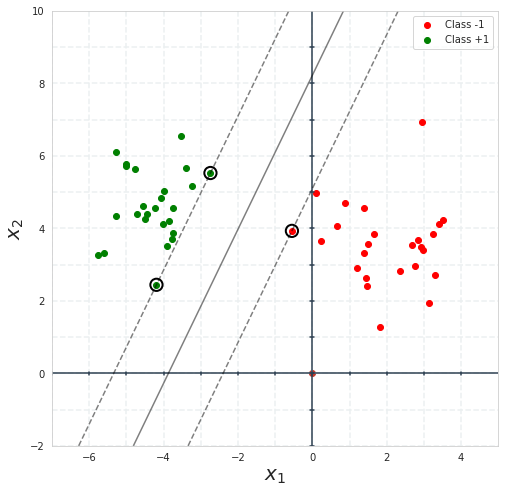

In [8]:
plt.figure(figsize=(8, 8))
draw_grid(x_lim=np.array([-7, 5]), y_lim=np.array([-2, 10]))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='r', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='g', label='Class +1')

plot_svc(clf)
# plot_hyperplane(w, b)

plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$x_2$', fontsize=20)
plt.legend()
plt.show()

## Soft-margin

If there is no separating hyperplane between the two classes, then there is no solution for the optimization problem stated above. To fix it we introduce the hinge loss function:

$$
\min_{\mathbf{w},b}\underbrace{\mathbf{w}^T\mathbf{w}}_{l_{2}-regularizer} + C\  \sum_{i=1}^{m}\underbrace{\max\left [ 1-y^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)}+b),0 \right ]}_{hinge-loss}        
$$

Note that $y^{(i)}$ is the i-th target, which is 1 or -1.

The function $\max\left [ 1-y^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)}+b),0 \right ]$ is zero if $x^{(i)}$ lies on the correct side of the hyperplane. For data points on the wrong side of the hyperplane, the function's value is proportional to the distance from the hyperplane.

The parameter C determines the trade-off between increasing the margin size and ensuring that every points lie on the correct side. Therefore, for sufficiently large values of $C$, the $l_{2}-regularizer$ will become negligible, hence, it will behave similar the hard-margin SVM.

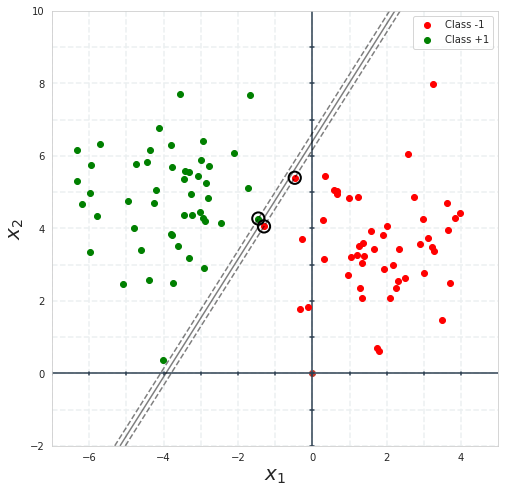

In [14]:
# Generate the training dataset
X, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=102, cluster_std=1.3)

plt.figure(figsize=(8, 8))

draw_grid(x_lim=np.array([-7, 5]), y_lim=np.array([-2, 10]))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='r', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='g', label='Class +1')

# Train and plot SVM model
clf = SVC(kernel='linear', C=1e3)
clf.fit(X, y)
plot_svc(clf)

plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$x_2$', fontsize=20)
plt.legend()
plt.show()

In [10]:
clf.coef_, clf.intercept_

(array([[-7.0056468 ,  4.31227684]]), array([-27.58841411]))